In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time

Load model

In [2]:
model = load_model("lstm.keras") # Load the model

Load Tokenizer

In [3]:
with open("tokenizer.pkl", "rb") as handle: # Load the tokenizer
    tokenizer = pickle.load(handle)

Load test data

In [4]:
df_test = pd.read_csv("../../../data/test_data.csv")

print("Length of test data:", len(df_test))
print(df_test.head())

Length of test data: 1938
        id                                               text  \
0  gg5ic5k  Thank you for sharing I have too many looming ...   
1  ghsx6oa  Alex Jones infowars.comSaid it will make you i...   
2  gidm2by  My dizziness this second time around hasn't be...   
3  gwe8ih0                       Yay!!! Thank you for sharing   
4  gr3f1r6  Thank you for your words! I hope I can get bet...   

               author                created_utc  No_of_comments  \
0        honeycombB82  2020-12-17 16:14:54+00:00             NaN   
1        StandupGamer  2021-01-02 05:52:26+00:00             NaN   
2              mjfx28  2021-01-07 02:13:41+00:00             NaN   
3            Rachet83  2021-04-30 06:18:38+00:00             NaN   
4  itsactuallynotokay  2021-03-16 05:35:11+00:00             NaN   

   Subjectivity  Polarity  Analysis   Parent    Link  
0      0.350000  0.237500  Positive   keq6mr  keq6mr  
1      0.000000  0.000000   Neutral   kof5pv  kof5pv  
2      0.

Preprocess the test data

In [5]:
X_test = tokenizer.texts_to_sequences(df_test["text"].astype(str)) # Convert text to sequences
max_len = 100  # Use the same max_len used during training
X_test = pad_sequences(X_test, maxlen=max_len) # Pad sequences to the same length

In [6]:
label_encoder = LabelEncoder() # Encode the labels
y_test = label_encoder.fit_transform(df_test["Analysis"])  # Use actual labels
y_test_cat = to_categorical(y_test)  # One-hot encoding if needed

Prediction

In [7]:
# # Evaluate
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")

accuracy_df = pd.DataFrame([{"Metric": "Overall Accuracy", "Score": accuracy}])
accuracy_df.to_csv("overall_accuracy_lstm.csv", index=False) # Save overall accuracy to CSV

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7683 - loss: 0.5860
Test Accuracy: 0.7683


In [8]:


# Initialize time for recording inference time
start = time.time()

y_pred = model.predict(X_test)

end = time.time()
inference_time = end - start

# Save inference time to CSV
df = pd.read_csv("computation_time_lstm.csv")  # Replace with your actual filename

df["lstm_InferenceTime (s)"] = inference_time

df.to_csv("computation_time_lstm.csv", index=False)

print("Inference time: ", inference_time, "seconds")
print("Inference time is saved")

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Inference time:  1.1243484020233154 seconds
Inference time is saved


Evaluation

Classification Report

In [9]:
y_pred_labels = np.argmax(y_pred, axis=1)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.65      0.52      0.58       431
     Neutral       0.73      0.84      0.78       450
    Positive       0.83      0.84      0.83      1057

    accuracy                           0.77      1938
   macro avg       0.74      0.73      0.73      1938
weighted avg       0.76      0.77      0.76      1938



Classification metrics per class

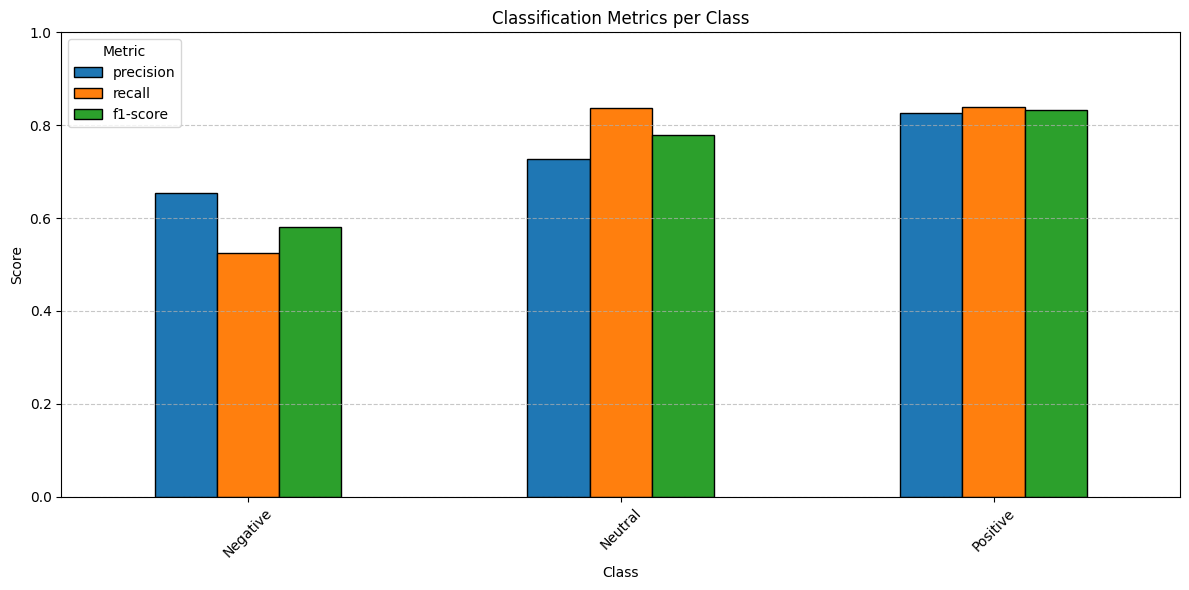

In [15]:
# Get the classification report as a dictionary
report_dict = classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Store to csv
report_df.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)
report_df[['precision', 'recall', 'f1-score']].to_csv("classification_report_lstm.csv") # Save classification report to CSV

# Plot grouped bar chart
report_df = report_df.drop(columns=["support"])
report_df.plot(kind="bar", figsize=(12, 6), edgecolor="black")

plt.title("Classification Metrics per Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("classification_report_lstm.png")
plt.show()


Confusion Matrix

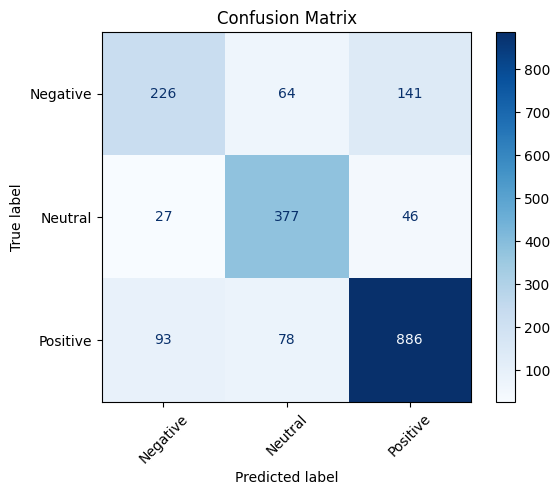

In [16]:
cm = confusion_matrix(y_test, y_pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_lstm.png")
plt.show()
